# Data Description

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
import re, string, unicodedata                          # Import Regex, string and unicodedata.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")

!pip install contractions
import contractions                                     # Import contractions library.
import nltk                                             # Import Natural Language Tool-Kit.
nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Get Data

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
df = pd.read_csv("/gdrive/MyDrive/Colab Notebooks/Tweets.csv")

In [4]:
df.shape

(14640, 15)

In [5]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [6]:
df.head

<bound method NDFrame.head of                  tweet_id  ...               user_timezone
0      570306133677760513  ...  Eastern Time (US & Canada)
1      570301130888122368  ...  Pacific Time (US & Canada)
2      570301083672813571  ...  Central Time (US & Canada)
3      570301031407624196  ...  Pacific Time (US & Canada)
4      570300817074462722  ...  Pacific Time (US & Canada)
...                   ...  ...                         ...
14635  569587686496825344  ...                         NaN
14636  569587371693355008  ...                         NaN
14637  569587242672398336  ...                         NaN
14638  569587188687634433  ...  Eastern Time (US & Canada)
14639  569587140490866689  ...                         NaN

[14640 rows x 15 columns]>

# Explore Data

In [7]:
# check for nonunique values
nonunique_cols = [featr for featr in df.columns if len(df[featr].unique()) <2]
nonunique_cols

[]

All unique / no duplicates to address


In [8]:
# check for missing values
100*df.isna().sum()/len(df)

tweet_id                         0.000000
airline_sentiment                0.000000
airline_sentiment_confidence     0.000000
negativereason                  37.308743
negativereason_confidence       28.128415
airline                          0.000000
airline_sentiment_gold          99.726776
name                             0.000000
negativereason_gold             99.781421
retweet_count                    0.000000
text                             0.000000
tweet_coord                     93.039617
tweet_created                    0.000000
tweet_location                  32.329235
user_timezone                   32.923497
dtype: float64

airline sentiment and text columns have zero missing values

In [9]:
# drop all other columns except “text” and “airline_sentiment”.
# col_drop = ['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord']
col_drop = ['tweet_id', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone']

In [10]:
print(df.columns)
df=df.drop(labels=col_drop, axis='columns')
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')


Index(['airline_sentiment', 'text'], dtype='object')

In [11]:
df.head

<bound method NDFrame.head of       airline_sentiment                                               text
0               neutral                @VirginAmerica What @dhepburn said.
1              positive  @VirginAmerica plus you've added commercials t...
2               neutral  @VirginAmerica I didn't today... Must mean I n...
3              negative  @VirginAmerica it's really aggressive to blast...
4              negative  @VirginAmerica and it's a really big bad thing...
...                 ...                                                ...
14635          positive  @AmericanAir thank you we got on a different f...
14636          negative  @AmericanAir leaving over 20 minutes Late Flig...
14637           neutral  @AmericanAir Please bring American Airlines to...
14638          negative  @AmericanAir you have my money, you change my ...
14639           neutral  @AmericanAir we have 8 ppl so we need 2 know h...

[14640 rows x 2 columns]>

In [12]:
df.shape

(14640, 2)

In [13]:
pd.set_option('display.max_colwidth', None)
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [14]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [15]:
def PieChart(t_df):
    Lst = 100*t_df.value_counts()/len(t_df)
    
    # set data for pie chart
    labels = t_df.value_counts().index.values
    sizes =  Lst 
    
    # set labels
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.2f%%', shadow=True, startangle=90)
    ax1.axis('equal')  # equal aspect ratio to ensure pie is drawn as a circle.
    plt.show()

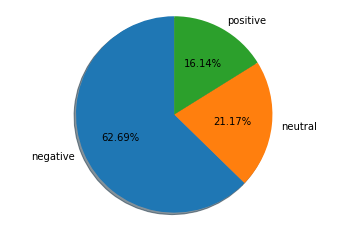

In [16]:
PieChart(df.airline_sentiment)

# Pre-Processing

In [17]:
# remove tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

df['text'] = df['text'].apply(lambda x: strip_html(x))
df.head()


,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [18]:
# language check
!pip install langdetect
from langdetect import detect

df['Language'] = ""

for i, desc in enumerate(df['text']):
    try:
        df['Language'][i] = detect(desc)
    except:
        df['Language'][i] = 'unknown'

In [19]:
pd.set_option('display.max_colwidth', None)
df.head()

,airline_sentiment,text,Language
0,neutral,@VirginAmerica What @dhepburn said.,en
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,en
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,en
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse",en
4,negative,@VirginAmerica and it's a really big bad thing about it,en


In [20]:
df['Language'].value_counts()

en    14447
fr       75
af       28
da       27
it       13
so        8
de        6
cy        6
ro        5
nl        4
id        4
et        3
tr        3
tl        2
ca        2
es        2
pt        2
no        1
sq        1
pl        1
Name: Language, dtype: int64

Remove non-english records

In [21]:
df=df[df['Language']=='en']

In [22]:
# remove numbers
def remove_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text

df['text'] = df['text'].apply(lambda x: remove_numbers(x))
df.head()


,airline_sentiment,text,Language
0,neutral,@VirginAmerica What @dhepburn said.,en
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,en
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,en
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse",en
4,negative,@VirginAmerica and it's a really big bad thing about it,en


In [23]:
# remove contractions
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

df['text'] = df['text'].apply(lambda x: replace_contractions(x))
df.head()

,airline_sentiment,text,Language
0,neutral,@VirginAmerica What @dhepburn said.,en
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.,en
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!,en
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse",en
4,negative,@VirginAmerica and it is a really big bad thing about it,en


In [24]:
# remove stop words
nltk.download('stopwords')
eng_stops = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
stopwords = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopwords = list(set(stopwords) - set(customlist))  

In [26]:
# remove proper nouns
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [27]:
for i, row in df.iterrows():
    sentence=df.at[i,'text']
    tagged_sentence = nltk.tag.pos_tag(sentence.split())
    edited_sentence = [word for word,tag in tagged_sentence if tag != 'NNP' and tag != 'NNPS']
    df.at[i,'text']=(' '.join(edited_sentence))
    
df.head()

,airline_sentiment,text,Language
0,neutral,@VirginAmerica What said.,en
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.,en
2,neutral,@VirginAmerica I did not today... mean I need to take another trip!,en
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse",en
4,negative,@VirginAmerica and it is a really big bad thing about it,en


In [28]:
# tokenization
df['text'] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) 
df.head()

,airline_sentiment,text,Language
0,neutral,"[@, VirginAmerica, What, said, .]",en
1,positive,"[@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]",en
2,neutral,"[@, VirginAmerica, I, did, not, today, ..., mean, I, need, to, take, another, trip, !]",en
3,negative,"[@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]",en
4,negative,"[@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]",en


In [29]:
# normalize: remove special chars, lower case, remove punctuation, remove stop words, lemmatize or stemming, and join the words in the list to convert back to text string in the dataframe
lemmatizer = WordNetLemmatizer()

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

df['text'] = df.apply(lambda row: normalize(row['text']), axis=1)
df.head()


,airline_sentiment,text,Language
0,neutral,virginamerica say,en
1,positive,virginamerica plus add commercials experience tacky,en
2,neutral,virginamerica not today mean need take another trip,en
3,negative,virginamerica really aggressive blast obnoxious entertainment guests face little recourse,en
4,negative,virginamerica really big bad thing,en


In [45]:
df['airline_sentiment'].value_counts()

negative    9119
neutral     3003
positive    2325
Name: airline_sentiment, dtype: int64

In [47]:
def PieChart(t_df):
    Lst = 100*t_df.value_counts()/len(t_df)
    
    # set data for pie chart
    labels = t_df.value_counts().index.values
    sizes =  Lst 
    
    # set labels
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.2f%%', shadow=True, startangle=90)
    ax1.axis('equal')  # equal aspect ratio to ensure pie is drawn as a circle.
    plt.show()

# Vectorize

In [30]:
# Vectorization via CountVectorizer (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer
vectorizer1 = CountVectorizer(max_features=1000)                # Keep only 1000 features as number of features will increase the processing time.
data_features1 = vectorizer1.fit_transform(df['text'])
data_features1 = data_features1.toarray()                       # Convert the data features to array.

In [31]:
print(vectorizer1.vocabulary_)

{'virginamerica': 943, 'say': 767, 'plus': 667, 'add': 13, 'experience': 319, 'not': 595, 'today': 887, 'mean': 542, 'need': 581, 'take': 861, 'another': 51, 'trip': 904, 'really': 711, 'entertainment': 294, 'face': 326, 'little': 510, 'big': 110, 'bad': 92, 'thing': 873, 'seriously': 782, 'would': 988, 'pay': 642, 'flight': 357, 'seat': 772, 'play': 663, 'fly': 362, 'yes': 995, 'nearly': 580, 'every': 305, 'time': 883, 'go': 396, 'away': 87, 'miss': 564, 'https': 439, 'amaze': 42, 'arrive': 70, 'hour': 433, 'early': 277, 'good': 398, 'know': 481, 'second': 773, 'lead': 489, 'pretty': 682, 'much': 573, 'better': 108, 'great': 399, 'deal': 232, 'think': 875, 'nd': 578, 'even': 301, 'st': 827, 'yet': 997, 'sky': 804, 'travel': 899, 'http': 438, 'schedule': 768, 'still': 839, 'excite': 313, 'first': 351, 'cross': 217, 'country': 207, 'hear': 415, 'nothing': 598, 'things': 874, 'last': 485, 'week': 962, 'could': 204, 'sit': 801, 'due': 275, 'two': 914, 'either': 281, 'side': 795, 'awesome'

In [32]:
data_features1.shape

(14447, 1000)

In [33]:
data_features1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [34]:
df.head()

,airline_sentiment,text,Language
0,neutral,virginamerica say,en
1,positive,virginamerica plus add commercials experience tacky,en
2,neutral,virginamerica not today mean need take another trip,en
3,negative,virginamerica really aggressive blast obnoxious entertainment guests face little recourse,en
4,negative,virginamerica really big bad thing,en


In [35]:
labels1 = df['airline_sentiment']
#labels = labels.astype('int')

In [36]:
# Vectorization via TfidfVectorizer for bag of words model
#vectorizer2 = TfidfVectorizer()
#train_tfidf_model = vectorizer2.fit_transform(train_tweets)
#test_tfidf_model = vectorizer2.transform(test_tweets)

In [37]:
# Vectorization via TfidfVectorizer for bag of words model
vectorizer2 = TfidfVectorizer()
data_features2 = vectorizer2.fit_transform(df['text'])
data_features2 = data_features2.toarray()
data_features2.shape

(14447, 9881)

In [49]:
data_features2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Fit and evaluate model using both types of vectorization

## Model with CountVectorizer

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_features1, labels1, test_size=0.3, random_state=42)

In [39]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest1 = RandomForestClassifier(n_estimators=10, n_jobs=4)
forest1 = forest1.fit(X_train, y_train)
print(forest1)
print(np.mean(cross_val_score(forest1, data_features1, labels1, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.6876175368306032


In [40]:
# Predict the result for test data using the model built above.

result1 = forest1.predict(X_test)

[[2334  233  123]
 [ 395  421  107]
 [ 208  175  339]]


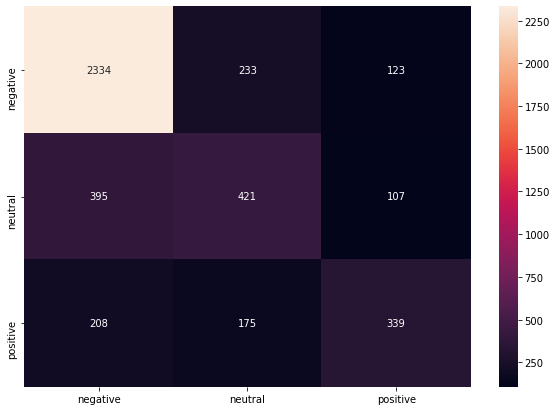

In [44]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, result1)
print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ["negative", "neutral","positive"]],
                  columns = [i for i in ["negative", "neutral","positive"]])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

## Model with TfidfVectorizer

In [51]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest2 = RandomForestClassifier(n_estimators=10, n_jobs=4)
forest2 = forest2.fit(X_train, y_train)
print(forest2)
print(np.mean(cross_val_score(forest2, data_features2, labels1, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7004907552070854


In [52]:
result2 = forest2.predict(X_test)

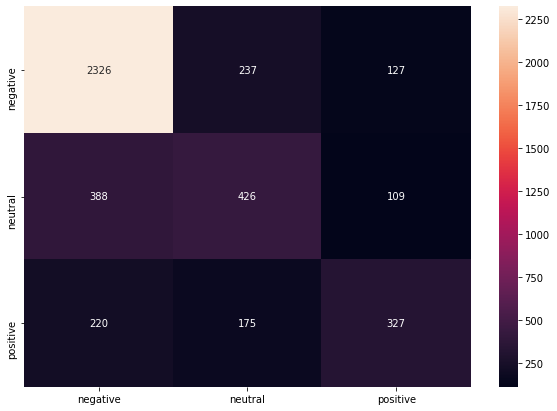

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result2)
df_cm = pd.DataFrame(conf_mat, index = [i for i in ["negative", "neutral","positive"]],
                  columns = [i for i in ["negative", "neutral","positive"]])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

# Summary

Applying TfidfVectorizer results in better accuracy than applying CountVectorizer.
